# Is COVID-19 Affecting Census Response Rates?

### By Benjamin Livingston, [*NewsCounts*](http://newscounts.org)
### March 21, 2020

## Introduction

COVID-19 has shut down much of America, including [the United States Census Bureau's field operations](https://www.nytimes.com/2020/03/18/us/virus-census-homeless.html).

This raises the question - it there a correlation between COVID-19 prevalence and census response rates?

We aim to answer that question with a brief exploration here.

To do this, we examined [county-level COVID-19](https://www.nytimes.com/interactive/2020/us/coronavirus-us-cases.html#g-cases-by-county) data that was readily available, and paired it with the official census return rate numbers to gauge a possible connection. We then generated infection rates for each county by normalizing on each county's population estimate from the 2018 American Community Survey.

There are a few important caveats here:
* COVID-19 data is generally highly inaccurate
* On a similar note, many cases in some states have not been assigned to a county, and have a county label as "unknown"; thus, while examining data at the county level gives us the power of granularity, there is some information loss
* The vast majority of counties have zero reported cases - thus, we will consider two models, one including those zero values, and one not including those zero values.

Our findings are presented below.

# Code

In [415]:
# import packages
import pandas as pd
import requests
from json import JSONDecodeError
import numpy as np

# define api key
key = '2988f01f5e86175bda8beae2b5035e1ccef2d052'

# get column names 
url = f"https://api.census.gov/data/2020/dec/responserate?get=GEO_ID,CRRALL,CRRINT,DAVG,DINTAVG,DRRALL,DRRINT&key={key}&for=state:*"
JSONContent = requests.get(url).json()
labels = pd.DataFrame(JSONContent).iloc[0,:-1]
county_responses = pd.DataFrame(columns=labels)

# pull county response data
for i in range(79):
    if i < 10:
        url = f"https://api.census.gov/data/2020/dec/responserate?get=GEO_ID,CRRALL,CRRINT,DAVG,DINTAVG,DRRALL,DRRINT&key={key}&for=county:*&in=state:0"\
        + str(i)
    else:
        url = f"https://api.census.gov/data/2020/dec/responserate?get=GEO_ID,CRRALL,CRRINT,DAVG,DINTAVG,DRRALL,DRRINT&key={key}&for=county:*&in=state:"\
        + str(i)
    try:
        JSONContent = requests.get(url).json()
        temp = pd.DataFrame(JSONContent)
        temp.columns = temp.iloc[0]
        temp = temp.iloc[1:,:]
        county_responses = pd.concat([county_responses,temp],sort=True)
    except JSONDecodeError:
        pass
    
"""
Pairing New York Times COVID-19 data from 3/21 with census response rate data from 

NYT source:
https://www.nytimes.com/interactive/2020/us/coronavirus-us-cases.html#g-cases-by-county
"""

# read COVID-19 data
covid = pd.read_csv('covid_data.csv',encoding="ISO-8859–1")

# integrate state abbreviations 
state_names = pd.read_csv('state_abbreviations.csv')
covid = pd.merge(covid,state_names,'inner','state')
covid = covid.drop(columns='state')
covid.columns = ['county','cases','state']

# integrate county codes
county_fips = pd.read_csv('county_fips.csv')
covid.county = covid.county.str.replace(' ','').replace('.','').replace(',','').replace("''","")
county_fips.county = county_fips.county.str.replace(' ','').replace('.','').replace(',','').replace("''","")
covid = pd.merge(covid,county_fips,'inner',['state','county'])

# parse cases to integer
covid = covid.iloc[:,[1,3]]
covid.cases = covid.cases.str.replace(',','') 
covid.cases = covid.cases.astype('int')

# pull out fips code
county_responses['fips'] = county_responses['GEO_ID'].str[-5:].astype('int')

# get names of variables
stats = county_responses.columns[:-4]

# change variables to floats
for column in stats:
    county_responses[column] = county_responses[column].astype('float')

# pull population data to incorporate
populations = pd.DataFrame(columns=['B01003_001E','county','state'])
for i in range(79):
    if i < 10:
        url = f'https://api.census.gov/data/2018/acs/acs5?get=B01003_001E&key={key}&for=county:*&in=state:0'\
        + str(i)
    else:
        url = f'https://api.census.gov/data/2018/acs/acs5?get=B01003_001E&key={key}&for=county:*&in=state:'\
        + str(i)
    try:
        JSONContent = requests.get(url).json()
        temp = pd.DataFrame(JSONContent)
        temp.columns = temp.iloc[0]
        temp = temp.iloc[1:,:]
        populations = pd.concat([populations,temp],sort=True)
    except JSONDecodeError:
        pass
populations.columns = ['population','county','state']

# merge population data into county reponses
county_responses = pd.merge(county_responses,populations,'inner',on=['state','county'])
county_responses = county_responses.drop(columns=['GEO_ID','county','state'])

# parse population to float
county_responses.population = county_responses.population.astype('float')

# merge data for all counties
with_unreported = pd.merge(covid,county_responses,'right','fips')
with_unreported.cases = with_unreported.cases.fillna(0)
for column in stats:
    with_unreported[column] = with_unreported[column].replace(0,np.nan)
with_unreported['cases'] = with_unreported['cases'] / with_unreported['population']
with_unreported = with_unreported.drop(columns=['fips','population'])

# merge data for only counties with reported cases
without_unreported = pd.merge(covid,county_responses,'inner','fips')
for column in stats:
    without_unreported[column] = without_unreported[column].replace(0,np.nan)
without_unreported['cases'] = without_unreported['cases'] / without_unreported['population']
without_unreported = without_unreported.drop(columns=['fips','population'])

# rename variables
variables = ['COVID-19 Cases',\
             'Cumulative Self-Response Rate - Overall',\
            'Cumulative Self-Response Rate - Internet',\
            'Average Daily Overall Self-Response Rate',\
            'Average Daily Internet Self-Response Rate',\
            'Maximum Daily Intenet Self-Response Rate',\
            'Median Daily Internet Self-Response Rate']

with_unreported.columns = variables
without_unreported.columns = variables

## Results

We will use a log scale for COVID-19 cases, in order to properly reflect that they are growing exponentially. In short, this will allow us to better model the effect COVID-19 is having on census reponse rates than a normal linear model would.

For reference while reading these results:
* “Internet” rates are calculated as the percent of all housing units who responded online. 
* “Overall” response rates are calculated as the percent of online, mail, and phone self-responses collectively. 
* Correlations range on a constant scale from -1 (perfectly negatively correlated), to 0 (absolutely no correlation), to 1 (perfectly positively correlated) - which is to say if a value is very close to zero, two factors are not correlated.

### All Counties

Factoring in *all counties* - not just those with reported cases - we see a fairly substantial negative correlation between COVID-19 cases and census self-response rates. 

This means that where there are more COVID-19 cases, people tend to fill out their census forms less, to a pretty noticeable degree.

In [416]:
with_unreported_log = with_unreported.copy()
with_unreported_log = with_unreported_log.replace(0,1)
with_unreported_log['COVID-19 Cases'] = np.log(with_unreported_log['COVID-19 Cases'])

results = pd.DataFrame(with_unreported_log.corr().round(2).iloc[3:5,0])
results.columns = ['Correlation with COVID-19 infection rates']
results

,Correlation with COVID-19 infection rates
Average Daily Overall Self-Response Rate,-0.36
Average Daily Internet Self-Response Rate,-0.40


### Only Counties With Reported COVID-19 Cases

We see a weaker effect while factoring in only those counties with reported COVID-19 cases, and not taking into account the vast number of counties with zero cases. Still, there's a negative correlation.

In [417]:
without_unreported_log = without_unreported.copy()
without_unreported_log = without_unreported_log.replace(0,1)
without_unreported_log['COVID-19 Cases'] = np.log(without_unreported_log['COVID-19 Cases'])

results = pd.DataFrame(without_unreported_log.corr().round(2).iloc[3:5,0])
results.columns = ['Correlation With COVID-19 infection rates']
results

,Correlation With COVID-19 infection rates
Average Daily Overall Self-Response Rate,-0.22
Average Daily Internet Self-Response Rate,-0.23


It should be noted that we checked to make sure that these numbers were robust to outliers, and they held up even with a handful of the most heavily-infected counties held out.

## Visualization

We'll present two graphs. 

First, an overall look that includes outliers and areas without cases.

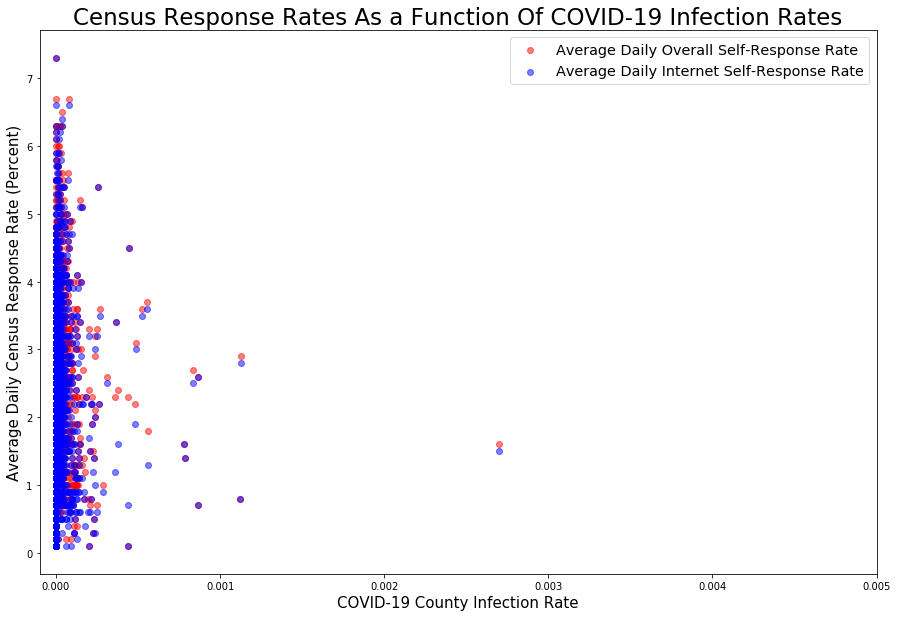

In [421]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.scatter(with_unreported['COVID-19 Cases'],\
            with_unreported['Average Daily Overall Self-Response Rate'],\
           color='r',alpha=0.5)
plt.scatter(with_unreported['COVID-19 Cases'],\
            with_unreported['Average Daily Internet Self-Response Rate'],\
            color='b',alpha=0.5)
plt.title('Census Response Rates As a Function Of COVID-19 Infection Rates',size=23)
labels=['Average Daily Overall Self-Response Rate','Average Daily Internet Self-Response Rate']
plt.legend(fontsize='x-large')
plt.xlabel('COVID-19 County Infection Rate',size=15)
plt.ylabel('Average Daily Census Response Rate (Percent)',size=15)
plt.xlim(-.0001,.005)
plt.show()

Second, we "zoom in", ignoring areas that have not had a COVID-19 case yet, and also "cropping out" the outliers to the right to give us a better idea of the overall trend.

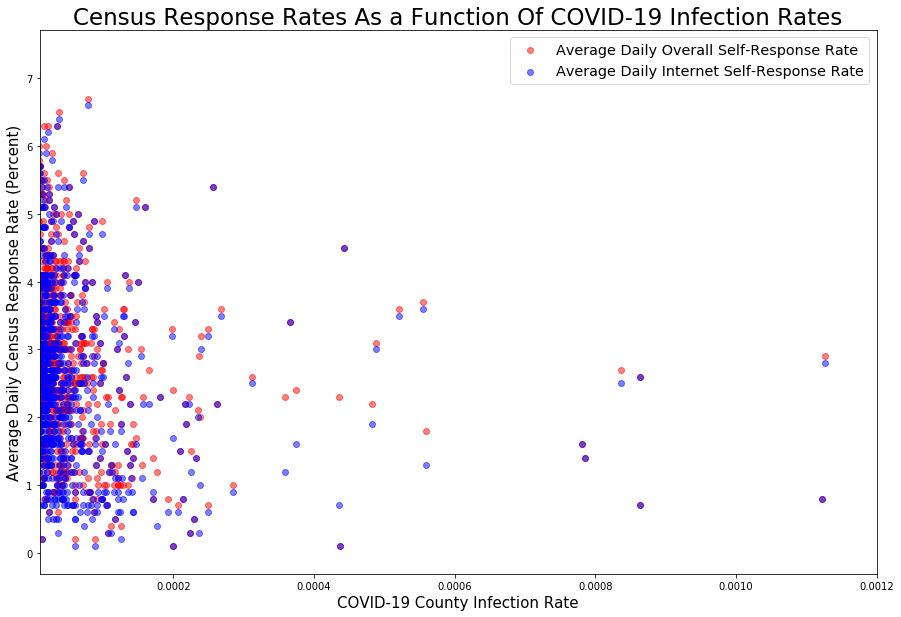

In [419]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.scatter(with_unreported['COVID-19 Cases'],\
            with_unreported['Average Daily Overall Self-Response Rate'],\
           color='r',alpha=0.5)
plt.scatter(with_unreported['COVID-19 Cases'],\
            with_unreported['Average Daily Internet Self-Response Rate'],\
            color='b',alpha=0.5)
plt.title('Census Response Rates As a Function Of COVID-19 Infection Rates',size=23)
labels=['Average Daily Overall Self-Response Rate','Average Daily Internet Self-Response Rate']
plt.legend(fontsize='x-large')
plt.xlabel('COVID-19 County Infection Rate',size=15)
plt.ylabel('Average Daily Census Response Rate (Percent)',size=15)
plt.xlim(.00001,.0012)
plt.show()

## Conclusion

Overall, we find that counties with higher infection rates have generally filled out census forms at a slower rate.

It is very important to note that confounding variables may play a role here, so we can't claim that COVID-19 is slowing census responses. It may be that certain demographic characteristics that lead to higher COVID-19 infection rates also lead to lower census response rates.

As an example of how these numbers can be misleading, note that the *raw* number of COVID-19 cases is actually *positively* correlated with census return rates, possibly because urban areas [typically have higher return rates than rural areas](https://bwliv.github.io/undercount_modeling).

That being said, we do observe that higher COVID-19 infection rates have tended to pair with somewhat lower census response rates.